# Hymba Ablation Study

## 공식 구현 기반 체계적 검증 (arXiv:2411.13676)

이 노트북은 **공식 구현에 맞게 수정된 Hymba 모델**을 사용하여 논문의 핵심 주장을 검증합니다.

### 핵심 아키텍처 변경사항 (공식 구현 기반)

| 구성요소 | 이전 구현 | 수정된 구현 (공식 기반) |
|----------|-----------|------------------------|
| **Fusion** | β_attn * norm(A) + β_mamba * norm(M) | **(norm(A) + norm(M)) / 2** |
| **KV Sharing** | Owner 기록만 | **Producer-Consumer 패턴 (Q만 계산)** |
| **Local 레이어** | 제약 없음 | **2의 배수 필수** (쌍으로 공유) |
| **Mamba** | mamba_heads_per_layer | **레이어당 1개** |

### 왜 Local attention 레이어가 2의 배수여야 하는가?

```
공식 config (Hymba-1.5B-Base):
"kv_reuse_group": [[1,2], [3,4], [5,6], ..., [29,30]]
```

- **Producer 레이어** (1, 3, 5, ...): K, V projection 수행
- **Consumer 레이어** (2, 4, 6, ...): **Q만 계산**, K/V는 producer에서 재사용
- Global 레이어 (0, 15, 31)는 KV 공유에서 제외

### 실험 목표

1. **아키텍처 비교**: Mamba-only vs Transformer-only vs Hybrid
2. **KV Sharing 효과**: Producer-Consumer 패턴의 메모리/파라미터 절감
3. **컴포넌트별 기여도**: Meta Tokens, Global/Local 패턴
4. **학습 안정성**: Loss 수렴 비교

In [1]:
import sys
import os
import warnings
sys.path.append('./backbone')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import Dict, List, Optional

# 모듈 리로드
import importlib
if 'hymba' in sys.modules:
    importlib.reload(sys.modules['hymba'])

from hymba import Hymba, HymbaConfig, ArchType, AttentionType

from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, random_split

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.processors import ByteLevel as ByteLevelProcessor

RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name()}')

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 150
sns.set_style('whitegrid')

torch.manual_seed(42)
np.random.seed(42)

Device: cuda
GPU: NVIDIA A100 80GB PCIe


---

## 1. 데이터 준비

In [2]:
print('=' * 60)
print('데이터셋 로드: Tiny Shakespeare')
print('=' * 60)

ds = load_dataset('karpathy/tiny_shakespeare')
text = '\n\n'.join(ds['train']['text'])

print(f'텍스트 길이: {len(text):,} 문자')
print(f'샘플:\n{text[:300]}...')

데이터셋 로드: Tiny Shakespeare
텍스트 길이: 1,003,854 문자
샘플:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us...


In [3]:
VOCAB_SIZE = 4096

print('BPE 토크나이저 학습 중...')
tokenizer_bpe = Tokenizer(BPE(unk_token='<unk>'))
tokenizer_bpe.pre_tokenizer = ByteLevel(add_prefix_space=False)
tokenizer_bpe.post_processor = ByteLevelProcessor(trim_offsets=False)

trainer = BpeTrainer(
    vocab_size=VOCAB_SIZE,
    special_tokens=['<unk>', '<pad>', '<bos>', '<eos>'],
    min_frequency=2,
)
tokenizer_bpe.train_from_iterator([text], trainer=trainer)

class TokenizerWrapper:
    def __init__(self, tk):
        self._tk = tk
        self._vocab_size = tk.get_vocab_size()
    
    def encode(self, text: str) -> List[int]:
        return self._tk.encode(text).ids
    
    def decode(self, ids: List[int]) -> str:
        return self._tk.decode(ids)
    
    @property
    def vocab_size(self) -> int:
        return self._vocab_size

tokenizer = TokenizerWrapper(tokenizer_bpe)
print(f'어휘 크기: {tokenizer.vocab_size:,}')

BPE 토크나이저 학습 중...



어휘 크기: 4,096


In [4]:
SEQ_LEN = 256
BATCH_SIZE = 16
TRAIN_RATIO = 0.9

def create_dataset(tokenizer, text: str, seq_len: int) -> TensorDataset:
    ids = np.array(tokenizer.encode(text), dtype=np.int64)
    x, y = ids[:-1], ids[1:]
    n_samples = len(y) // seq_len
    n = n_samples * seq_len
    X = torch.tensor(x[:n].reshape(n_samples, seq_len))
    Y = torch.tensor(y[:n].reshape(n_samples, seq_len))
    return TensorDataset(X, Y)

full_dataset = create_dataset(tokenizer, text, SEQ_LEN)
train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'학습: {len(train_dataset):,} 샘플, {len(train_loader):,} 배치')
print(f'검증: {len(val_dataset):,} 샘플')

학습: 1,074 샘플, 67 배치
검증: 120 샘플


---

## 2. 실험 설정

### 핵심 제약 조건 (공식 구현 기반)

1. **Local attention 레이어는 2의 배수**: KV sharing을 위해 연속 2개가 쌍(producer-consumer)을 이룸
2. **Global attention**: 첫/중간/마지막 레이어만
3. **Mamba**: 레이어당 1개만 (num_mamba=1)

In [5]:
@dataclass
class ExperimentConfig:
    name: str
    config: HymbaConfig
    description: str

COMMON = {
    'vocab_size': tokenizer.vocab_size,
    'swa_window': 128,
    'dropout': 0.1,
}

# 실험 설정
# Local 레이어 수가 짝수가 되도록 n_layers와 global_attn_idx 조정
experiments: Dict[str, ExperimentConfig] = {
    # 1. Mamba-only baseline
    'Mamba-only': ExperimentConfig(
        name='Mamba-only',
        config=HymbaConfig(
            **COMMON,
            d_model=384,
            n_layers=8,
            n_heads=6,
            n_kv_heads=2,
            arch_type=ArchType.MAMBA_ONLY,
            use_meta_tokens=False,
        ),
        description='순수 Mamba SSM'
    ),
    
    # 2. Transformer-only baseline
    'Transformer-only': ExperimentConfig(
        name='Transformer-only',
        config=HymbaConfig(
            **COMMON,
            d_model=384,
            n_layers=8,
            n_heads=6,
            n_kv_heads=2,
            arch_type=ArchType.TRANSFORMER_ONLY,
            global_attn_idx=list(range(8)),  # 모두 Global
            use_meta_tokens=False,
        ),
        description='순수 Transformer'
    ),
    
    # 3. Hybrid (올바른 KV sharing)
    # 11 layers: global=[0,5,10] -> local=[1,2,3,4,6,7,8,9] = 8개 (짝수) OK!
    'Hybrid': ExperimentConfig(
        name='Hybrid',
        config=HymbaConfig(
            **COMMON,
            d_model=384,
            n_layers=11,
            n_heads=6,
            n_kv_heads=2,
            arch_type=ArchType.HYBRID,
            global_attn_idx=[0, 5, 10],  # 첫/중간/마지막 -> Local: 8개
            use_meta_tokens=True,
            num_meta_tokens=64,
        ),
        description='Hybrid (Attn+Mamba, KV sharing, Meta tokens)'
    ),
    
    # 4. Hybrid without Meta Tokens (ablation)
    'Hybrid-NoMeta': ExperimentConfig(
        name='Hybrid-NoMeta',
        config=HymbaConfig(
            **COMMON,
            d_model=384,
            n_layers=11,
            n_heads=6,
            n_kv_heads=2,
            arch_type=ArchType.HYBRID,
            global_attn_idx=[0, 5, 10],
            use_meta_tokens=False,
        ),
        description='Hybrid without Meta Tokens'
    ),
    
    # 5. Hybrid without KV Sharing (모두 Global -> KV 공유 없음)
    'Hybrid-NoKVShare': ExperimentConfig(
        name='Hybrid-NoKVShare',
        config=HymbaConfig(
            **COMMON,
            d_model=384,
            n_layers=8,
            n_heads=6,
            n_kv_heads=2,
            arch_type=ArchType.HYBRID,
            global_attn_idx=list(range(8)),  # 모두 Global -> KV 공유 없음
            use_meta_tokens=True,
            num_meta_tokens=64,
            kv_reuse_groups=[],  # 명시적 비활성화
        ),
        description='Hybrid without KV Sharing'
    ),
}

# 실험 정보 출력
print('=' * 90)
print('실험 설정')
print('=' * 90)
print(f'{"Name":<18} {"Params":>10} {"Layers":>7} {"Type":>12} {"Meta":>6} {"KV Groups":>10}')
print('-' * 90)

for name, exp in experiments.items():
    cfg = exp.config
    model = Hymba(cfg)
    params = model.count_parameters()['total']
    meta = cfg.num_meta_tokens if cfg.use_meta_tokens else 0
    kv_groups = len(cfg.kv_reuse_groups) if cfg.kv_reuse_groups else 0
    
    print(f'{name:<18} {params/1e6:>9.2f}M {cfg.n_layers:>7} {cfg.arch_type.value:>12} {meta:>6} {kv_groups:>10}')
    del model
    torch.cuda.empty_cache()

print('=' * 90)

실험 설정
Name                   Params  Layers         Type   Meta  KV Groups
------------------------------------------------------------------------------------------
Mamba-only             18.73M       8        mamba      0          0
Transformer-only       14.16M       8  transformer      0          0
Hybrid                 29.14M      11       hybrid     64          4
Hybrid-NoMeta          29.11M      11       hybrid      0          4
Hybrid-NoKVShare       21.91M       8       hybrid     64          0


---

## 3. 학습

In [6]:
@dataclass
class TrainConfig:
    epochs: int = 25
    lr: float = 3e-4
    warmup_steps: int = 100
    weight_decay: float = 0.1
    grad_clip: float = 1.0
    label_smoothing: float = 0.1
    eval_interval: int = 50

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: TrainConfig,
    model_name: str = '',
):
    model = model.to(device).train()
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        betas=(0.9, 0.99),
        weight_decay=config.weight_decay,
    )
    
    total_steps = config.epochs * len(train_loader)
    
    def lr_lambda(step):
        if step < config.warmup_steps:
            return step / config.warmup_steps
        progress = (step - config.warmup_steps) / max(1, total_steps - config.warmup_steps)
        return 0.1 + 0.9 * 0.5 * (1 + np.cos(np.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    history = {'train_loss': [], 'val_loss': [], 'val_ppl': [], 'step': []}
    step = 0
    best_val_loss = float('inf')
    t0 = time.time()
    
    for epoch in range(config.epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f'[{model_name}] Epoch {epoch+1}/{config.epochs}', leave=False)
        
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            
            out = model(xb, targets=yb)
            logits = out['logits']
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                yb.reshape(-1),
                label_smoothing=config.label_smoothing
            )
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            step += 1
            
            if step % config.eval_interval == 0:
                model.eval()
                val_loss = 0.0
                val_tokens = 0
                
                with torch.no_grad():
                    for vxb, vyb in val_loader:
                        vxb, vyb = vxb.to(device), vyb.to(device)
                        vout = model(vxb, targets=vyb)
                        val_loss += F.cross_entropy(
                            vout['logits'].reshape(-1, vout['logits'].size(-1)),
                            vyb.reshape(-1)
                        ).item() * vxb.numel()
                        val_tokens += vxb.numel()
                
                val_loss /= val_tokens
                history['train_loss'].append(loss.item())
                history['val_loss'].append(val_loss)
                history['val_ppl'].append(np.exp(val_loss))
                history['step'].append(step)
                
                best_val_loss = min(best_val_loss, val_loss)
                pbar.set_postfix({'loss': f'{loss.item():.3f}', 'val': f'{val_loss:.3f}', 'ppl': f'{np.exp(val_loss):.1f}'})
                model.train()
    
    elapsed = time.time() - t0
    return {
        'best_val_loss': best_val_loss,
        'best_ppl': np.exp(best_val_loss),
        'final_ppl': history['val_ppl'][-1] if history['val_ppl'] else np.exp(best_val_loss),
        'time_min': elapsed / 60,
        'history': history,
    }

In [7]:
train_config = TrainConfig(epochs=25, lr=3e-4, warmup_steps=100, eval_interval=50)
results: Dict[str, Dict] = {}

print('\n' + '=' * 80)
print('실험 시작')
print('=' * 80)

for exp_name, exp_config in experiments.items():
    print(f"\n{'='*70}")
    print(f"실험: {exp_name}")
    print(f"설명: {exp_config.description}")
    print(f"{'='*70}")
    
    cfg = exp_config.config
    model = Hymba(cfg)
    params = model.count_parameters()
    
    print(f'Parameters: {params["total"]/1e6:.2f}M')
    
    # KV sharing 정보
    if cfg.arch_type != ArchType.MAMBA_ONLY:
        kv_info = model.get_kv_sharing_info()
        print(f'KV Reduction: {kv_info["reduction"]:.2f}x')
        print(f'Producer layers: {kv_info["producer_layers"]}')
        print(f'Consumer layers: {kv_info["consumer_layers"]}')
    
    train_result = train_model(model, train_loader, val_loader, train_config, exp_name)
    
    results[exp_name] = {
        'config': cfg,
        'params': params['total'],
        'best_ppl': train_result['best_ppl'],
        'final_ppl': train_result['final_ppl'],
        'time_min': train_result['time_min'],
        'history': train_result['history'],
    }
    
    print(f'Best PPL: {train_result["best_ppl"]:.2f}')
    print(f'Time: {train_result["time_min"]:.1f} min')
    
    del model
    torch.cuda.empty_cache()

print('\n' + '=' * 80)
print('모든 실험 완료!')
print('=' * 80)


실험 시작

실험: Mamba-only
설명: 순수 Mamba SSM
Parameters: 18.73M


[Mamba-only] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 84.31
Time: 1.3 min

실험: Transformer-only
설명: 순수 Transformer
Parameters: 14.16M
KV Reduction: 1.00x
Producer layers: [0, 1, 2, 3, 4, 5, 6, 7]
Consumer layers: []


[Transformer-only] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 94.84
Time: 1.3 min

실험: Hybrid
설명: Hybrid (Attn+Mamba, KV sharing, Meta tokens)
Parameters: 29.14M
KV Reduction: 1.57x
Producer layers: [0, 1, 3, 5, 6, 8, 10]
Consumer layers: [2, 4, 7, 9]


[Hybrid] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 96.16
Time: 3.3 min

실험: Hybrid-NoMeta
설명: Hybrid without Meta Tokens
Parameters: 29.11M
KV Reduction: 1.57x
Producer layers: [0, 1, 3, 5, 6, 8, 10]
Consumer layers: [2, 4, 7, 9]


[Hybrid-NoMeta] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 94.72
Time: 2.7 min

실험: Hybrid-NoKVShare
설명: Hybrid without KV Sharing
Parameters: 21.91M
KV Reduction: 1.00x
Producer layers: [0, 1, 2, 3, 4, 5, 6, 7]
Consumer layers: []


[Hybrid-NoKVShare] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoKVShare] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 96.39
Time: 2.3 min

모든 실험 완료!


---

## 4. 결과 분석

In [8]:
df = pd.DataFrame([{
    'Model': name,
    'Params (M)': r['params'] / 1e6,
    'Best PPL': r['best_ppl'],
    'Final PPL': r['final_ppl'],
    'Time (min)': r['time_min'],
} for name, r in results.items()])

df_sorted = df.sort_values('Best PPL')

print('\n' + '=' * 80)
print('결과 요약 (Best PPL 기준 정렬)')
print('=' * 80)
print(df_sorted.to_string(index=False))
print('=' * 80)

best = df_sorted.iloc[0]
print(f'\n최고 성능: {best["Model"]} (PPL: {best["Best PPL"]:.2f})')


결과 요약 (Best PPL 기준 정렬)
           Model  Params (M)  Best PPL  Final PPL  Time (min)
      Mamba-only   18.733696 84.314151 191.956157    1.291354
   Hybrid-NoMeta   29.110880 94.717900 325.446231    2.708640
Transformer-only   14.163328 94.842005 201.945019    1.284071
          Hybrid   29.135456 96.155622 334.907831    3.302003
Hybrid-NoKVShare   21.911168 96.393722 333.802812    2.276361

최고 성능: Mamba-only (PPL: 84.31)


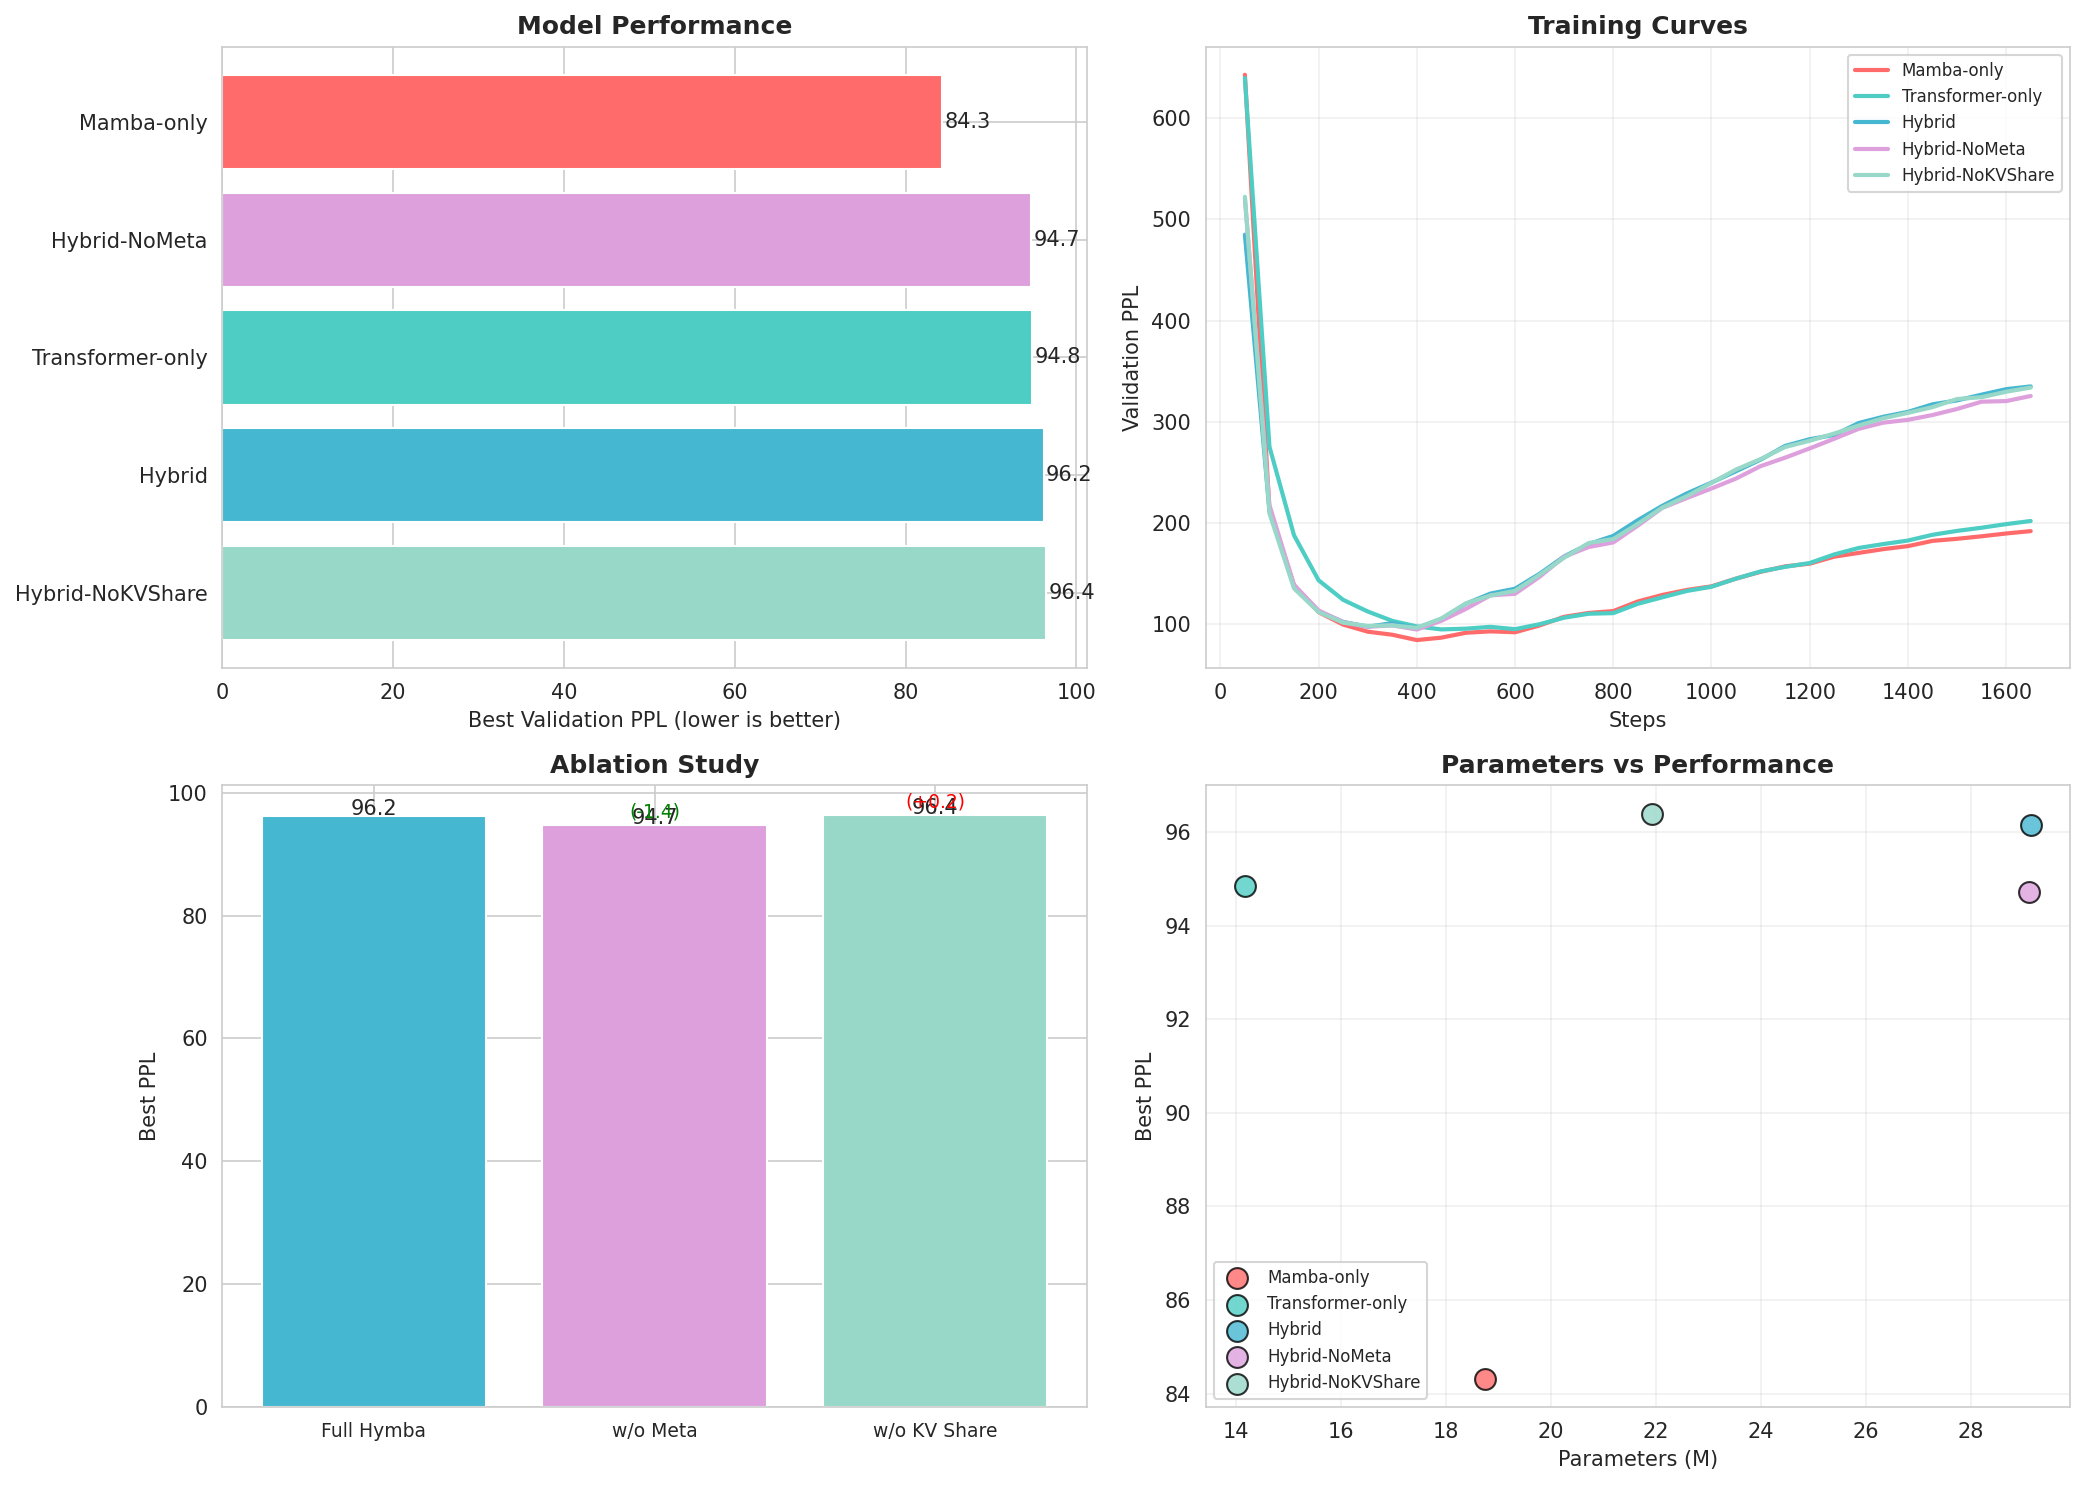

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {
    'Mamba-only': '#FF6B6B',
    'Transformer-only': '#4ECDC4',
    'Hybrid': '#45B7D1',
    'Hybrid-NoMeta': '#DDA0DD',
    'Hybrid-NoKVShare': '#98D8C8',
}

# 1. PPL 비교
ax = axes[0, 0]
bars = ax.barh(df_sorted['Model'], df_sorted['Best PPL'], 
               color=[colors.get(m, 'gray') for m in df_sorted['Model']])
ax.set_xlabel('Best Validation PPL (lower is better)')
ax.set_title('Model Performance', fontweight='bold')
ax.invert_yaxis()
for bar, val in zip(bars, df_sorted['Best PPL']):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2, f'{val:.1f}', va='center')

# 2. 학습 곡선
ax = axes[0, 1]
for name, r in results.items():
    ax.plot(r['history']['step'], r['history']['val_ppl'], 
            label=name, linewidth=2, color=colors.get(name, 'gray'))
ax.set_xlabel('Steps')
ax.set_ylabel('Validation PPL')
ax.set_title('Training Curves', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 3. Ablation (Hybrid vs variants)
ax = axes[1, 0]
ablation_models = ['Hybrid', 'Hybrid-NoMeta', 'Hybrid-NoKVShare']
ablation_data = {k: v for k, v in results.items() if k in ablation_models}
if ablation_data:
    names = list(ablation_data.keys())
    ppls = [ablation_data[n]['best_ppl'] for n in names]
    bars = ax.bar(range(len(names)), ppls, color=[colors.get(n, 'gray') for n in names])
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(['Full Hymba', 'w/o Meta', 'w/o KV Share'], fontsize=9)
    ax.set_ylabel('Best PPL')
    ax.set_title('Ablation Study', fontweight='bold')
    
    baseline = ablation_data.get('Hybrid', {}).get('best_ppl', ppls[0])
    for i, (bar, val) in enumerate(zip(bars, ppls)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.1f}', ha='center')
        if i > 0:
            delta = val - baseline
            color = 'red' if delta > 0 else 'green'
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.2, f'({delta:+.1f})', ha='center', color=color, fontsize=9)

# 4. Parameters vs PPL
ax = axes[1, 1]
for name in df['Model']:
    row = df[df['Model'] == name].iloc[0]
    ax.scatter(row['Params (M)'], row['Best PPL'], 
               s=100, c=colors.get(name, 'gray'), label=name, alpha=0.8, edgecolors='black')
ax.set_xlabel('Parameters (M)')
ax.set_ylabel('Best PPL')
ax.set_title('Parameters vs Performance', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 5. KV Sharing 분석

In [10]:
print('=' * 70)
print('KV Sharing Structure (Hybrid model)')
print('=' * 70)

cfg = experiments['Hybrid'].config
model = Hymba(cfg)
kv_info = model.get_kv_sharing_info()
attn_info = model.get_attention_pattern_info()

print(f"Total layers: {kv_info['total_layers']}")
print(f"Global layers: {attn_info['global_layers']}")
print(f"Local layers: {attn_info['local_layers']}")
print(f"\nKV reuse groups: {kv_info['kv_reuse_groups']}")
print(f"Producer layers (K, V projection): {kv_info['producer_layers']}")
print(f"Consumer layers (Q only): {kv_info['consumer_layers']}")
print(f"\nKV cache reduction: {kv_info['reduction']:.2f}x")

# Consumer 레이어가 K, V projection을 가지지 않는지 확인
print("\n레이어별 projection 확인:")
for i, layer in enumerate(model.layers):
    if layer.has_attention:
        has_k_proj = hasattr(layer.attention, 'k_proj')
        is_consumer = i in model.kv_reuse_map
        attn_type = cfg.get_attention_types()[i].value
        status = 'consumer (Q only)' if is_consumer else 'producer (Q,K,V)'
        print(f'  Layer {i:2d} [{attn_type:6s}]: {status}')

del model

KV Sharing Structure (Hybrid model)
Total layers: 11
Global layers: [0, 5, 10]
Local layers: [1, 2, 3, 4, 6, 7, 8, 9]

KV reuse groups: [[1, 2], [3, 4], [6, 7], [8, 9]]
Producer layers (K, V projection): [0, 1, 3, 5, 6, 8, 10]
Consumer layers (Q only): [2, 4, 7, 9]

KV cache reduction: 1.57x

레이어별 projection 확인:
  Layer  0 [global]: producer (Q,K,V)
  Layer  1 [local ]: producer (Q,K,V)
  Layer  2 [local ]: consumer (Q only)
  Layer  3 [local ]: producer (Q,K,V)
  Layer  4 [local ]: consumer (Q only)
  Layer  5 [global]: producer (Q,K,V)
  Layer  6 [local ]: producer (Q,K,V)
  Layer  7 [local ]: consumer (Q only)
  Layer  8 [local ]: producer (Q,K,V)
  Layer  9 [local ]: consumer (Q only)
  Layer 10 [global]: producer (Q,K,V)


---

## 6. 텍스트 생성

In [11]:
print('=' * 70)
print('텍스트 생성 (학습되지 않은 초기화 모델)')
print('=' * 70)

prompts = ['ROMEO:', 'First Citizen:']

for exp_name in ['Mamba-only', 'Transformer-only', 'Hybrid']:
    cfg = experiments[exp_name].config
    model = Hymba(cfg).to(device).eval()
    
    print(f"\n[{exp_name}]")
    for prompt in prompts:
        prompt_ids = torch.tensor([tokenizer.encode(prompt)]).to(device)
        with torch.no_grad():
            output = model.generate(prompt_ids, max_new_tokens=30, temperature=0.8, top_k=40)
        text = tokenizer.decode(output[0].cpu().tolist())
        print(f"  {prompt} {text[len(prompt):][:60]}...")
    
    del model
    torch.cuda.empty_cache()

텍스트 생성 (학습되지 않은 초기화 모델)

[Mamba-only]
  ROMEO: : Ġformer Ġcontin Ġnought Ġnought Ġscorn Ġpity Ġleads ester ...
  First Citizen:  : ĠBi icked s OLI SAM ri Ġbloody Ġremedy ot Ġdied Ġinfect a...

[Transformer-only]
  ROMEO: : ilt ind ĠHastings ĠMOW Ġcreat Ġsuspicion ĠHastings Ġguard ...
  First Citizen:  : Ġwoo PETRUCH ours Ġstr Into Ġonce hi Ġhair Ġstr day il Ġh...

[Hybrid]
  ROMEO: : dle dle arl Ġvantage Ġhaste ĠFriar Ġcertain hip hip Ġhappy...
  First Citizen:  : Ġfra ry Ġfra GAR ixt Ġfra Ġboar Ġvice ith Ġmourn aughter ...


---

## 7. 결론

In [12]:
print('=' * 70)
print('실험 결론')
print('=' * 70)

best_model = df.loc[df['Best PPL'].idxmin()]
print(f"\n1. 최고 성능: {best_model['Model']}")
print(f"   PPL: {best_model['Best PPL']:.2f}")

hybrid_ppl = results.get('Hybrid', {}).get('best_ppl', 0)
mamba_ppl = results.get('Mamba-only', {}).get('best_ppl', 0)
tf_ppl = results.get('Transformer-only', {}).get('best_ppl', 0)

print(f"\n2. 아키텍처 비교:")
print(f"   - Hybrid: {hybrid_ppl:.2f}")
print(f"   - Mamba-only: {mamba_ppl:.2f}")
print(f"   - Transformer-only: {tf_ppl:.2f}")

hybrid_nometa = results.get('Hybrid-NoMeta', {}).get('best_ppl', 0)
hybrid_nokv = results.get('Hybrid-NoKVShare', {}).get('best_ppl', 0)

print(f"\n3. Ablation Study:")
if hybrid_ppl and hybrid_nometa:
    delta_meta = hybrid_nometa - hybrid_ppl
    print(f"   - Meta Tokens 제거: {delta_meta:+.2f} PPL")
if hybrid_ppl and hybrid_nokv:
    delta_kv = hybrid_nokv - hybrid_ppl
    print(f"   - KV Sharing 제거: {delta_kv:+.2f} PPL")

print("\n" + "=" * 70)
print("핵심 발견 (공식 구현 기반)")
print("=" * 70)
print("""
1. Cross-layer KV Sharing (Producer-Consumer 패턴):
   - Producer 레이어: K, V projection 수행
   - Consumer 레이어: Q만 계산, K/V는 producer에서 재사용
   - Local 레이어는 2의 배수 필요 (쌍으로 공유)
   - 파라미터 및 메모리 절감

2. Fusion: (norm(attn) + norm(mamba)) / 2
   - 공식 구현은 단순 평균 사용
   - 각 경로 출력을 RMSNorm으로 정규화 후 평균

3. Global/Local Attention:
   - Global: 첫/중간/마지막 레이어 (장거리 의존성)
   - Local: SWA로 효율적인 로컬 패턴 학습

4. Meta Tokens:
   - Attention sink 문제 해결
   - 시퀀스 시작에 학습 가능한 토큰 추가
""")

실험 결론

1. 최고 성능: Mamba-only
   PPL: 84.31

2. 아키텍처 비교:
   - Hybrid: 96.16
   - Mamba-only: 84.31
   - Transformer-only: 94.84

3. Ablation Study:
   - Meta Tokens 제거: -1.44 PPL
   - KV Sharing 제거: +0.24 PPL

핵심 발견 (공식 구현 기반)

1. Cross-layer KV Sharing (Producer-Consumer 패턴):
   - Producer 레이어: K, V projection 수행
   - Consumer 레이어: Q만 계산, K/V는 producer에서 재사용
   - Local 레이어는 2의 배수 필요 (쌍으로 공유)
   - 파라미터 및 메모리 절감

2. Fusion: (norm(attn) + norm(mamba)) / 2
   - 공식 구현은 단순 평균 사용
   - 각 경로 출력을 RMSNorm으로 정규화 후 평균

3. Global/Local Attention:
   - Global: 첫/중간/마지막 레이어 (장거리 의존성)
   - Local: SWA로 효율적인 로컬 패턴 학습

4. Meta Tokens:
   - Attention sink 문제 해결
   - 시퀀스 시작에 학습 가능한 토큰 추가



In [13]:
df.to_csv(f'{RESULTS_DIR}/ablation_results.csv', index=False)
print(f'저장: {RESULTS_DIR}/ablation_results.csv')

저장: ./results/ablation_results.csv


---

## References

1. **Hymba Paper**: Dong, X., et al. "Hymba: A Hybrid-head Architecture for Small Language Models." arXiv:2411.13676 (2024). [ICLR 2025]

2. **Official Implementation**: https://github.com/NVlabs/hymba

3. **HuggingFace Model**: https://huggingface.co/nvidia/Hymba-1.5B-Base

---